# 프로젝트 - Movielens 영화 SBR🎞️

## Session-Based Recommendation이란?
* SBR은 말 그대로 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천을 말합니다. Session이란 앞에서 살펴보았듯이 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장됩니다. 유저의 행동 데이터들은 유저 측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고받습니다. 이번 자료에서는 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터와 같은 의미로 사용하겠습니다.

In [3]:
import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Data Load
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


# Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
# Session Length
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [8]:
session_length.min(), session_length.max()

(20, 2314)

In [9]:
session_length.quantile(0.999)

1343.181000000005

In [10]:
long_session = session_length[session_length==200].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
406366,2438,908,3,2000-11-14 17:28:41
406379,2438,2294,3,2000-11-14 17:28:41
406412,2438,3812,5,2000-11-14 17:28:41
406418,2438,3835,2,2000-11-14 17:28:41
406427,2438,1186,4,2000-11-14 17:28:41
...,...,...,...,...
406356,2438,3948,4,2001-01-18 04:27:56
406461,2438,2502,4,2001-02-04 04:46:41
406372,2438,1466,4,2001-02-04 21:43:09
406413,2438,1131,5,2001-04-13 02:08:11


In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

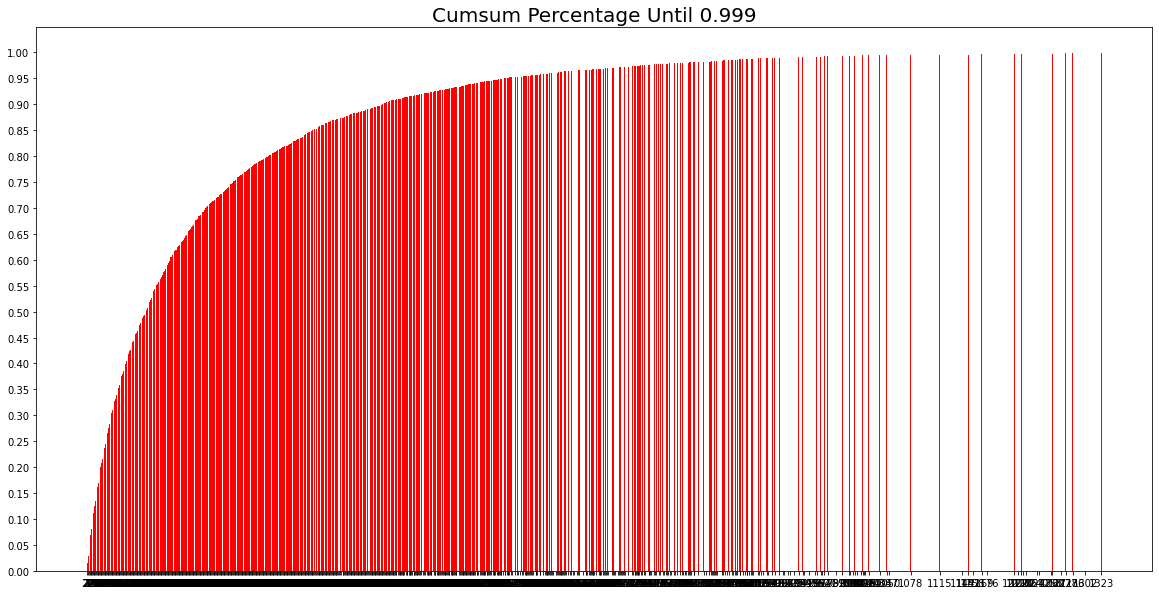

In [12]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [13]:
# Session Time
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [14]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
# Data Cleansing
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_view):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_view].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
user_view = data.groupby('UserId').size()
movie_view = data.groupby('ItemId').size()

print(user_view.mean())
print(movie_view.mean())

165.5975165562914
269.88909875876953


In [18]:
data = cleanse_recursive(data, shortest=2, least_view=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [19]:
# Train / Valid / Test split
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [20]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [21]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 860249
	 Sessions: 5701
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 00:14:13

* valid Set Stats Info
	 Events: 41662
	 Sessions: 106
	 Items: 3030
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 97700
	 Sessions: 233
	 Items: 3279
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### SessionDataset
* 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.
* train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
* click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
* session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [25]:
# SessionDataset
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [26]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [27]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 859785, 859908, 860249], dtype=int32)

In [28]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5698, 5699, 5700])

# Step 2. 미니 배치의 구성
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### SessionDataLoader
* SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
* __iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
* mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [31]:
iter_ex = iter(tr_data_loader)

In [32]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# Step 3. 모델 구성
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

### Evaluation Metric
* 모델 성능에 대한 지표로 precision이나 recall이 있습니다.
* Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다. 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.
* 추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다. 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.
* 이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture
* 스텝 3에서 소개한 GRU4REC모델 구조를 구현하겠습니다. 모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [36]:
#model = create_model(args)

# Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
# train_model(model, args)

# 학습된 모델을 불러옵니다.
#model = tf.keras.models.load_model(data_path / 'trained_model')

# Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [38]:
# 첫번째 모델
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:39<01:25,  3.50it/s]


	 - Recall@20 epoch 1: 0.252634
	 - MRR@20    epoch 1: 0.066181



Evaluation:  54%|█████▍    | 350/649 [01:37<01:22,  3.61it/s]


	 - Recall@20 epoch 2: 0.297366
	 - MRR@20    epoch 2: 0.083092



Evaluation:  54%|█████▍    | 350/649 [01:35<01:21,  3.66it/s]


	 - Recall@20 epoch 3: 0.310268
	 - MRR@20    epoch 3: 0.089338



Evaluation:  54%|█████▍    | 350/649 [01:35<01:21,  3.68it/s]


	 - Recall@20 epoch 4: 0.316384
	 - MRR@20    epoch 4: 0.093155



Evaluation:  54%|█████▍    | 350/649 [01:35<01:21,  3.68it/s]

	 - Recall@20 epoch 5: 0.318750
	 - MRR@20    epoch 5: 0.095672



In [40]:
# 두번째 모델
args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1055400   
_________________________________________________________________
dropout_2 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_2 (Dense)              (64, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:37<01:22,  3.61it/s]


	 - Recall@20 epoch 1: 0.281429
	 - MRR@20    epoch 1: 0.078113



Evaluation:  54%|█████▍    | 350/649 [01:34<01:20,  3.72it/s]


	 - Recall@20 epoch 2: 0.313214
	 - MRR@20    epoch 2: 0.092958



Evaluation:  54%|█████▍    | 350/649 [01:33<01:20,  3.73it/s]


	 - Recall@20 epoch 3: 0.321607
	 - MRR@20    epoch 3: 0.096690



Evaluation:  54%|█████▍    | 350/649 [01:33<01:19,  3.75it/s]


	 - Recall@20 epoch 4: 0.324955
	 - MRR@20    epoch 4: 0.097960



Evaluation:  54%|█████▍    | 350/649 [01:33<01:19,  3.76it/s]

	 - Recall@20 epoch 5: 0.326295
	 - MRR@20    epoch 5: 0.099040



In [41]:
# 세번째 모델
args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1055400   
_________________________________________________________________
dropout_3 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_3 (Dense)              (64, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:35<01:21,  3.68it/s]


	 - Recall@20 epoch 1: 0.273884
	 - MRR@20    epoch 1: 0.077094



Evaluation:  54%|█████▍    | 350/649 [01:33<01:19,  3.76it/s]


	 - Recall@20 epoch 2: 0.309063
	 - MRR@20    epoch 2: 0.090686



Evaluation:  54%|█████▍    | 350/649 [01:33<01:19,  3.76it/s]


	 - Recall@20 epoch 3: 0.321339
	 - MRR@20    epoch 3: 0.094915



Evaluation:  54%|█████▍    | 350/649 [01:32<01:19,  3.78it/s]


	 - Recall@20 epoch 4: 0.325670
	 - MRR@20    epoch 4: 0.098501



Evaluation:  54%|█████▍    | 350/649 [01:32<01:19,  3.78it/s]

	 - Recall@20 epoch 5: 0.329196
	 - MRR@20    epoch 5: 0.099822



In [42]:
# 네번째 모델
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      520200    
_________________________________________________________________
dropout_4 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (32, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  77%|███████▋  | 999/1298 [02:35<00:46,  6.43it/s]


	 - Recall@20 epoch 1: 0.246184
	 - MRR@20    epoch 1: 0.065808



Evaluation:  77%|███████▋  | 999/1298 [02:32<00:45,  6.57it/s]


	 - Recall@20 epoch 2: 0.279498
	 - MRR@20    epoch 2: 0.079882



Evaluation:  77%|███████▋  | 999/1298 [02:31<00:45,  6.61it/s]


	 - Recall@20 epoch 3: 0.289884
	 - MRR@20    epoch 3: 0.084732



Evaluation:  77%|███████▋  | 999/1298 [02:31<00:45,  6.60it/s]


	 - Recall@20 epoch 4: 0.293794
	 - MRR@20    epoch 4: 0.086259



Evaluation:  77%|███████▋  | 999/1298 [02:30<00:45,  6.63it/s]

	 - Recall@20 epoch 5: 0.293919
	 - MRR@20    epoch 5: 0.087902



In [43]:
# 다섯번째 모델
args = Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 100), (32, 100)]    1055400   
_________________________________________________________________
dropout_5 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_5 (Dense)              (32, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  77%|███████▋  | 999/1298 [02:33<00:45,  6.52it/s]


	 - Recall@20 epoch 1: 0.265828
	 - MRR@20    epoch 1: 0.075479



Evaluation:  77%|███████▋  | 999/1298 [02:31<00:45,  6.59it/s]


	 - Recall@20 epoch 2: 0.289946
	 - MRR@20    epoch 2: 0.085730



Evaluation:  77%|███████▋  | 999/1298 [02:30<00:45,  6.64it/s]


	 - Recall@20 epoch 3: 0.295483
	 - MRR@20    epoch 3: 0.088128



Evaluation:  77%|███████▋  | 999/1298 [02:30<00:45,  6.62it/s]


	 - Recall@20 epoch 4: 0.296328
	 - MRR@20    epoch 4: 0.089380



Evaluation:  77%|███████▋  | 999/1298 [02:30<00:45,  6.64it/s]

	 - Recall@20 epoch 5: 0.295139
	 - MRR@20    epoch 5: 0.089061



In [44]:
# 여섯번째 모델
args = Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 100), (32, 100)]    1055400   
_________________________________________________________________
dropout_6 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_6 (Dense)              (32, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  77%|███████▋  | 999/1298 [02:33<00:45,  6.51it/s]


	 - Recall@20 epoch 1: 0.261355
	 - MRR@20    epoch 1: 0.072897



Evaluation:  77%|███████▋  | 999/1298 [02:31<00:45,  6.59it/s]


	 - Recall@20 epoch 2: 0.290572
	 - MRR@20    epoch 2: 0.084105



Evaluation:  77%|███████▋  | 999/1298 [02:31<00:45,  6.60it/s]


	 - Recall@20 epoch 3: 0.297172
	 - MRR@20    epoch 3: 0.088239



Evaluation:  77%|███████▋  | 999/1298 [02:31<00:45,  6.61it/s]


	 - Recall@20 epoch 4: 0.299956
	 - MRR@20    epoch 4: 0.089726



Evaluation:  77%|███████▋  | 999/1298 [02:30<00:45,  6.63it/s]

	 - Recall@20 epoch 5: 0.299393
	 - MRR@20    epoch 5: 0.090228



In [45]:
# 일곱번째 모델
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(16, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      520200    
_________________________________________________________________
dropout_7 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_7 (Dense)              (16, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  90%|█████████ | 2347/2597 [03:37<00:23, 10.79it/s]


	 - Recall@20 epoch 1: 0.242171
	 - MRR@20    epoch 1: 0.065024



Evaluation:  90%|█████████ | 2347/2597 [03:35<00:22, 10.90it/s]


	 - Recall@20 epoch 2: 0.264140
	 - MRR@20    epoch 2: 0.074536



Evaluation:  90%|█████████ | 2347/2597 [03:34<00:22, 10.96it/s]


	 - Recall@20 epoch 3: 0.269493
	 - MRR@20    epoch 3: 0.076960



Evaluation:  90%|█████████ | 2347/2597 [03:35<00:22, 10.89it/s]


	 - Recall@20 epoch 4: 0.271011
	 - MRR@20    epoch 4: 0.078926



Evaluation:  90%|█████████ | 2347/2597 [03:35<00:22, 10.90it/s]

	 - Recall@20 epoch 5: 0.270691
	 - MRR@20    epoch 5: 0.079458



In [46]:
# 여덟번째 모델
args = Args(tr, val, test, batch_size=16, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(16, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 100), (16, 100)]    1055400   
_________________________________________________________________
dropout_8 (Dropout)          (16, 100)                 0         
_________________________________________________________________
dense_8 (Dense)              (16, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  90%|█████████ | 2347/2597 [03:37<00:23, 10.78it/s]


	 - Recall@20 epoch 1: 0.255219
	 - MRR@20    epoch 1: 0.070695



Evaluation:  90%|█████████ | 2347/2597 [03:35<00:22, 10.87it/s]


	 - Recall@20 epoch 2: 0.272342
	 - MRR@20    epoch 2: 0.077294



Evaluation:  90%|█████████ | 2347/2597 [03:35<00:22, 10.88it/s]


	 - Recall@20 epoch 3: 0.272476
	 - MRR@20    epoch 3: 0.079373



Evaluation:  90%|█████████ | 2347/2597 [03:35<00:22, 10.87it/s]


	 - Recall@20 epoch 4: 0.273195
	 - MRR@20    epoch 4: 0.079306



Evaluation:  90%|█████████ | 2347/2597 [03:34<00:22, 10.95it/s]

	 - Recall@20 epoch 5: 0.272156
	 - MRR@20    epoch 5: 0.078676



In [47]:
# 아홉번째 모델
args = Args(tr, val, test, batch_size=16, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(16, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 100), (16, 100)]    1055400   
_________________________________________________________________
dropout_9 (Dropout)          (16, 100)                 0         
_________________________________________________________________
dense_9 (Dense)              (16, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  90%|█████████ | 2347/2597 [03:36<00:23, 10.84it/s]


	 - Recall@20 epoch 1: 0.250213
	 - MRR@20    epoch 1: 0.069812



Evaluation:  90%|█████████ | 2347/2597 [03:34<00:22, 10.95it/s]


	 - Recall@20 epoch 2: 0.268588
	 - MRR@20    epoch 2: 0.076316



Evaluation:  90%|█████████ | 2347/2597 [03:33<00:22, 11.00it/s]


	 - Recall@20 epoch 3: 0.272609
	 - MRR@20    epoch 3: 0.077908



Evaluation:  90%|█████████ | 2347/2597 [03:35<00:22, 10.90it/s]


	 - Recall@20 epoch 4: 0.275138
	 - MRR@20    epoch 4: 0.079185



Evaluation:  90%|█████████ | 2347/2597 [03:34<00:22, 10.95it/s]

	 - Recall@20 epoch 5: 0.275352
	 - MRR@20    epoch 5: 0.080241



In [40]:
# 열번째 모델
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=7, k=20)
model = create_model(args)
train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  54%|█████▍    | 350/649 [01:36<01:22,  3.62it/s]


	 - Recall@20 epoch 1: 0.251786
	 - MRR@20    epoch 1: 0.065147



Evaluation:  54%|█████▍    | 350/649 [01:33<01:19,  3.76it/s]


	 - Recall@20 epoch 2: 0.295580
	 - MRR@20    epoch 2: 0.083183



Evaluation:  54%|█████▍    | 350/649 [01:31<01:18,  3.82it/s]


	 - Recall@20 epoch 3: 0.312768
	 - MRR@20    epoch 3: 0.091085



Evaluation:  54%|█████▍    | 350/649 [01:31<01:17,  3.84it/s]


	 - Recall@20 epoch 4: 0.320179
	 - MRR@20    epoch 4: 0.095252



Evaluation:  54%|█████▍    | 350/649 [01:31<01:17,  3.84it/s]


	 - Recall@20 epoch 5: 0.322411
	 - MRR@20    epoch 5: 0.097137



Evaluation:  54%|█████▍    | 350/649 [01:30<01:17,  3.86it/s]


	 - Recall@20 epoch 6: 0.323973
	 - MRR@20    epoch 6: 0.098541



Evaluation:  54%|█████▍    | 350/649 [01:30<01:17,  3.87it/s]

	 - Recall@20 epoch 7: 0.324955
	 - MRR@20    epoch 7: 0.099403



In [41]:
# 열한번째 모델
args = Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.25, lr=0.001, epochs=7, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 100), (32, 100)]    1055400   
_________________________________________________________________
dropout_1 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (32, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  77%|███████▋  | 999/1298 [02:28<00:44,  6.72it/s]


	 - Recall@20 epoch 1: 0.263983
	 - MRR@20    epoch 1: 0.074266



Evaluation:  77%|███████▋  | 999/1298 [02:27<00:44,  6.79it/s]


	 - Recall@20 epoch 2: 0.288945
	 - MRR@20    epoch 2: 0.084866



Evaluation:  77%|███████▋  | 999/1298 [02:26<00:43,  6.84it/s]


	 - Recall@20 epoch 3: 0.295201
	 - MRR@20    epoch 3: 0.088298



Evaluation:  77%|███████▋  | 999/1298 [02:25<00:43,  6.89it/s]


	 - Recall@20 epoch 4: 0.299550
	 - MRR@20    epoch 4: 0.089680



Evaluation:  77%|███████▋  | 999/1298 [02:25<00:43,  6.88it/s]


	 - Recall@20 epoch 5: 0.299393
	 - MRR@20    epoch 5: 0.089858



Evaluation:  77%|███████▋  | 999/1298 [02:25<00:43,  6.88it/s]


	 - Recall@20 epoch 6: 0.300988
	 - MRR@20    epoch 6: 0.089398



Evaluation:  77%|███████▋  | 999/1298 [02:25<00:43,  6.84it/s]

	 - Recall@20 epoch 7: 0.299393
	 - MRR@20    epoch 7: 0.089835



In [43]:
# 열두번째 모델
args = Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.25, lr=0.01, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 100), (32, 100)]    1055400   
_________________________________________________________________
dropout_3 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_3 (Dense)              (32, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  77%|███████▋  | 999/1298 [02:34<00:46,  6.48it/s]


	 - Recall@20 epoch 1: 0.200450
	 - MRR@20    epoch 1: 0.050487



Evaluation:  77%|███████▋  | 999/1298 [02:35<00:46,  6.43it/s]


	 - Recall@20 epoch 2: 0.194444
	 - MRR@20    epoch 2: 0.048353



Evaluation:  77%|███████▋  | 999/1298 [02:35<00:46,  6.44it/s]


	 - Recall@20 epoch 3: 0.198355
	 - MRR@20    epoch 3: 0.049599



Evaluation:  77%|███████▋  | 999/1298 [02:35<00:46,  6.43it/s]


	 - Recall@20 epoch 4: 0.201639
	 - MRR@20    epoch 4: 0.049838



Evaluation:  77%|███████▋  | 999/1298 [02:35<00:46,  6.44it/s]

	 - Recall@20 epoch 5: 0.196134
	 - MRR@20    epoch 5: 0.047340



In [44]:
test_model(model, args, test)

Evaluation:  91%|█████████ | 2756/3045 [07:16<00:45,  6.31it/s]

	 - Recall@20: 0.165389
	 - MRR@20: 0.041462



# 정리
1. Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.318750
    - MRR@20   : 0.095672
2. Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.326295
    - MRR@20   : 0.099040
3. Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.329196
    - MRR@20   : 0.099822
4. Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.293919
    - MRR@20   : 0.087902
5. Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.295139
    - MRR@20   : 0.089061
6. Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.299393
    - MRR@20   : 0.090228
7. Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.270691
    - MRR@20   : 0.079458
8. Args(tr, val, test, batch_size=16, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.272156
    - MRR@20   : 0.078676
9. Args(tr, val, test, batch_size=16, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)
    - Recall@20: 0.275352
    - MRR@20   : 0.080241
10. Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=7, k=20)
    - Recall@20: 0.324955
	- MRR@20   : 0.099403
11. Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.25, lr=0.001, epochs=7, k=20)
	- Recall@20: 0.299393
	- MRR@20   : 0.089835
12. Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.25, lr=0.01, epochs=5, k=20)
	- Recall@20: 0.165389
	- MRR@20   : 0.041462

# 회고
* batch_size를 64보다 크게 잡으면 IndexError: index 106 is out of bounds for axis 0 with size 106오류가 떠서 64이상의 batch_size모델을 테스트해볼수 없어 아쉬웠다.
* batch_size, hsz, drop_rate, Ir, epochs를 바꿔가며 시도한 모델들 중 세번째 모델인 (batch_size=64, hsz=100, drop_rate=0.25, lr=0.001, epochs=5, k=20)를 하이퍼파라미터로 가지는 모델의 성능이 가장 높게 나왔다.
* Recall과 MRR 말고도 다른 성능 지표를 쓰면 어떤 결과가 나올지 궁금하다. 